In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import nltk as nltk
from nltk import FreqDist
import re
import data_cred as cred
import folium
import seaborn as sns
from textblob import TextBlob
import string
import numpy as np
from wordcloud import WordCloud 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aperniah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
def connect_db(user,password,host,port,database):
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
            
    return connection

In [3]:
def cursor_init(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")  
    return cursor

In [4]:
def select_tuits(topic,cursor):
    #json.dumps(x)
    script = f"Select tweet,topic,city_searched,country_searched FROM data_tweets where topic = '{topic}'"
    cursor.execute(script)
    return cursor

In [5]:
def transform_data(cursor):
    tweets = []
    columns = cursor.description
    for t in cursor.fetchall():
        tweet = t[0]
        tweets.append([tweet['id'], 
                    tweet['full_text'],
                    tweet['retweet_count'],
                    tweet['favorite_count'],
                    tweet['created_at'],
                    tweet['user']['screen_name'], 
                    [i['screen_name'] for i in tweet['entities']['user_mentions']],
                    tweet['user']['description'],
                    tweet['user']['verified'],
                    tweet['user']['location'],
                    tweet['user']['statuses_count'], 
                    tweet['user']['followers_count'], 
                    tweet['user']['friends_count'], 
                    tweet['user']['favourites_count'], 
                    tweet['user']['created_at'], 
                    tweet['user']['profile_image_url'],
                    tweet['user']['created_at'],
                    t[1],
                    t[2],
                    t[3]])

    return tweets

In [33]:
topico_a='trump'
topico_b='biden'
topico_a2='donald trump'
topico_b2='joe biden'
columns = ['id' , 'full_text', 'retweet_count', 'favorite_count', 'created_at', 'user_screen_name' , 'user_mentions', 'user_description', 'user_verified', 'user_location', 'user_statuses_count' , 'user_followers_count' , 'user_friends_count' , 'user_favourites_count' , 'user_created_at' , 'user_profile_image_url', 'user_created_at', 'topic','city_searched','country_searched']

In [34]:
connection = connect_db(cred.database_user,cred.database_pass,"192.168.0.22",'5432','data_tweets')
cursor_a = cursor_init(connection)
cursor_b = cursor_init(connection)

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 



In [35]:
d_a = select_tuits(topico_a, cursor_a)

In [36]:
d_b = select_tuits(topico_b, cursor_b)

In [37]:
data_a = transform_data(d_a)


In [38]:
data_b = transform_data(d_b)


In [39]:
df_a = pd.DataFrame(data_a,columns=columns)
df_b = pd.DataFrame(data_b,columns=columns)


In [40]:
df_a['created_at'] = df_a['created_at'].apply(pd.to_datetime)
df_a['user_created_at'] = df_a['user_created_at'].apply(pd.to_datetime)

In [41]:
df_a.count()[1],df_b.count()[1]

(40069, 6856)

0         1401
1          137
2         9535
3         2472
4         4813
         ...  
30967    17247
30968     1793
30969     2548
30970      779
30971       65
Name: user_followers_count, Length: 30972, dtype: int64

In [42]:
def transform(text):
    stop_words_sp = set(stopwords.words('spanish'))
    stop_words_en = set(stopwords.words('english'))
    stopWords = stop_words_sp | stop_words_en
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    text = text.lower().replace(' ja ','')
    text = text.lower().replace(' va ','')
    text = text.lower().replace(' si ','')
    text = text.lower().replace(' ser ','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    no_garbage = [w for w in stripped if not w in stopWords]
    return (' '.join(no_garbage))

In [43]:
def transform2(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    text = ' '.join(stripped)
    text = re.findall(r'\w{4,}',  text) # Remover RTs
    text = ' '.join(text)
    return (text)

esto es un prueeeeebaffffdddddffffa deeeee sonido


In [44]:
df_a['tuit_text_transform'] = df_a ['full_text'].apply(transform)
df_b['tuit_text_transform'] = df_b ['full_text'].apply(transform)
df_a['tuit_text_transform2'] = df_a ['full_text'].apply(transform2)
df_b['tuit_text_transform2'] = df_b ['full_text'].apply(transform2)

0        como gente medianamente decente sentido humani...
1        nadie votó contra venezuela nadie votamos bols...
2                                          trumpesp espero
3                                       gusta donald trump
4                entiendo tiene foto obama trump mussolini
                               ...                        
39753    nuevamente twitter ejecuta bloqueo suave tuit ...
39754                  final cuanto falta para muera trump
39755    bolsas eeuu caen aplazarse conversaciones trum...
39756    trump suspendió diálogo demócratas plan ayuda ...
39757    trump suspendió diálogo demócratas plan ayuda ...
Name: tuit_text_transform, Length: 39758, dtype: object

In [45]:
def set_sentiment(text):
    sentiment=0
    text = str(text)
    if text != '':
        analysis = TextBlob(text)
        if len(analysis)>3:
            #if analysis.detect_language() == 'es':
            #analysis = analysis.translate(from_lang='es',to='en').sentiment
            sentiment = analysis.polarity
    return sentiment

In [46]:
df_a['polarity'] = df_a['full_text'].apply(set_sentiment)
df_b['polarity'] = df_b['full_text'].apply(set_sentiment)

In [47]:
df_a['polarity'].describe()

count    40069.000000
mean         0.001043
std          0.102467
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: polarity, dtype: float64

In [48]:
df_b['polarity'].describe()

count    6856.000000
mean        0.000630
std         0.103361
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polarity, dtype: float64

In [49]:
text_a = ' '.join(df_a.tuit_text_transform)
text_b = ' '.join(df_b.tuit_text_transform)
text_a = text_a.lower().replace(topico_a2,'')
text_b = text_b.lower().replace(topico_b2,'')
text_a = text_a.lower().replace(topico_a,'')
text_b = text_b.lower().replace(topico_b,'')
#
text_a = text_a.lower().replace(topico_b2,'')
text_b = text_b.lower().replace(topico_a2,'')
text_a = text_a.lower().replace(topico_b,'')
text_b = text_b.lower().replace(topico_a,'')
#

In [50]:
wordcloud_a = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_a)
wordcloud_b = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_b)

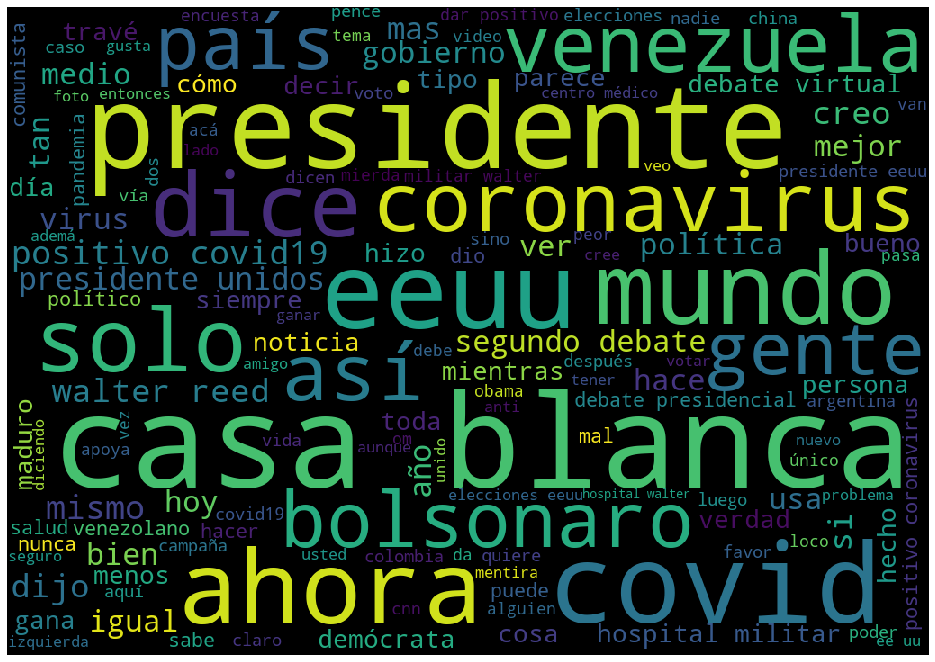

In [51]:
plt.figure(figsize=(16,9), facecolor=None)
plt.imshow(wordcloud_a)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/a_wordcloud.png')
plt.show()


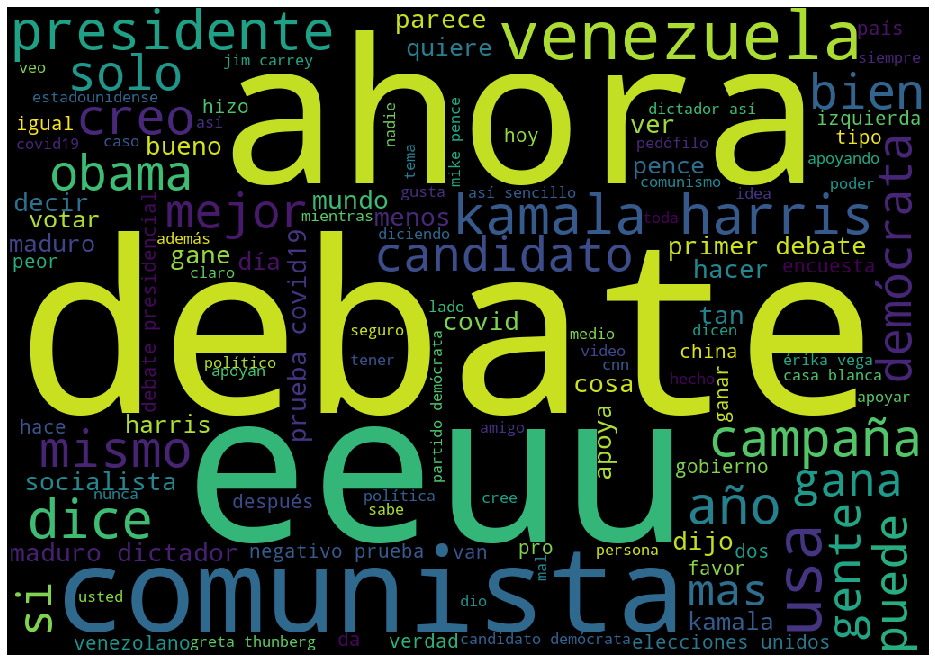

In [52]:
plt.figure(figsize=(16,9), facecolor=None)
plt.imshow(wordcloud_b)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/b_wordcloud.png')
plt.show()


In [102]:
def tokenice_ngrams(text, ngrams):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = text.replace('  ','')
    tokenized = text.split(" ")
    md_bigrams= list(nltk.ngrams(tokenized, ngrams))
    return md_bigrams


In [103]:
plt.rcParams.update({'font.size': 12})

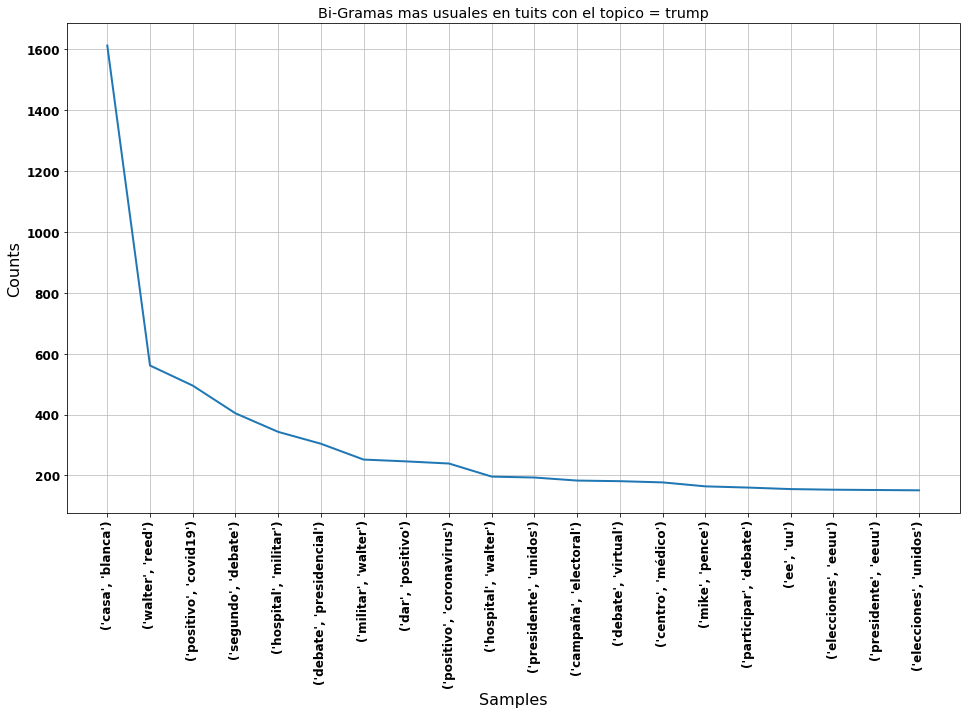

In [104]:
fdist_a = FreqDist(tokenice_ngrams(text_a, 2))
fig= plt.figure(figsize=(16,9), facecolor=None)
plt.title(f'Bi-Gramas mas usuales en tuits con el topico = {topico_a}')
plt.xlabel('Bigrams', fontsize=16)
plt.ylabel('Counts', fontsize=16)
fdist_a.plot(20)
fig.savefig('images/a_bigrams_more.png', dpi=fig.dpi)

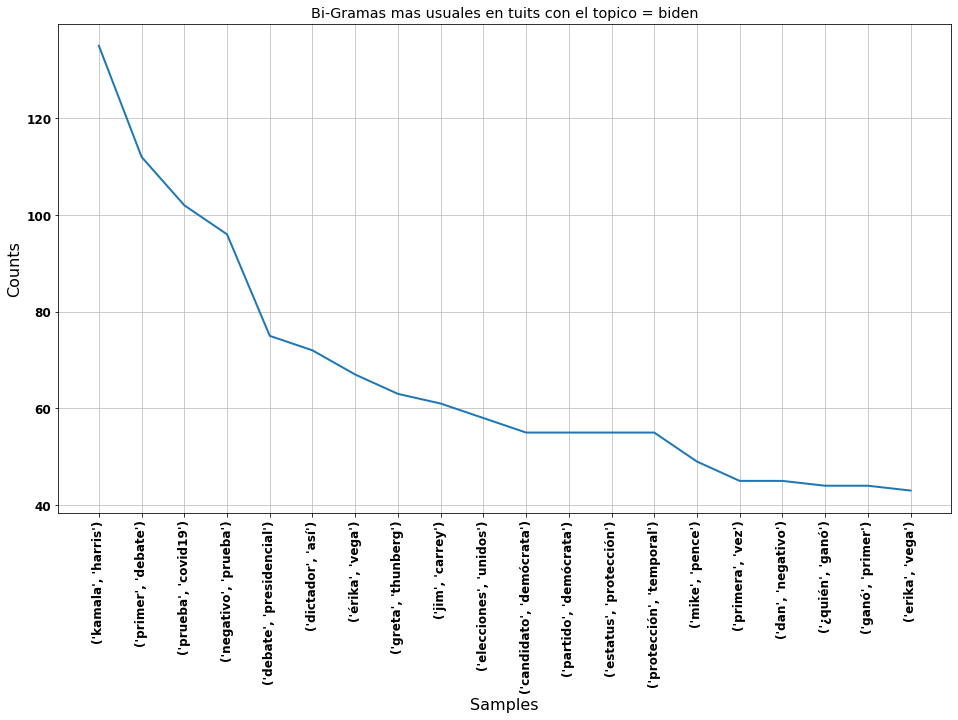

In [105]:
fdist_b = FreqDist(tokenice_ngrams(text_b, 2))
fig= plt.figure(figsize=(16,9), facecolor=None)
plt.title(f'Bi-Gramas mas usuales en tuits con el topico = {topico_b}')
plt.xlabel('Bigrams', fontsize=16)
plt.ylabel('Counts', fontsize=16)
fdist_b.plot(20)
fig.savefig('images/b_bigrams_more.png', dpi=fig.dpi)


In [56]:
threshold = 2
filtered_words = [ word for word in text_a.split() if len(word)>threshold]
filtered_word_dist = FreqDist(filtered_words)

In [57]:
md_bigrams = list(nltk.bigrams(text_a.split()))
filtered_bigrams = [bigram for bigram in md_bigrams if len(bigram[0])>threshold and len(bigram[1])>threshold]
filtered_bigrams_dist = FreqDist(filtered_bigrams)

In [58]:
df = pd.DataFrame()
df['bi_grams'] = list(set(fdist_a))
df['word_0'] = df['bi_grams'].apply(lambda x: x[0])
df['word_1'] = df['bi_grams'].apply(lambda x: x[1])
df['bi_gram_freq'] = df['bi_grams'].apply(lambda x: filtered_bigrams_dist[x] )
df['word_0_freq'] = df['word_0'].apply(lambda x: filtered_word_dist[x] )
df['word_1_freq'] = df['word_1'].apply(lambda x: filtered_word_dist[x] )

In [59]:
df['PMI'] = df[['bi_gram_freq','word_0_freq','word_1_freq']].apply(lambda x: np.log2(x.values[0]/(x.values[1]*x.values[2])), axis = 1)
df['log(bi_gram_freq)']=df['bi_gram_freq'].apply(lambda x: np.log2(x))
df.sort_values(by='PMI', ascending=False)

,bi_grams,word_0,word_1,bi_gram_freq,word_0_freq,word_1_freq,PMI,log(bi_gram_freq)
277663,"(covid29, ⚽tomás)",covid29,⚽tomás,1,1,1,0.0,0.0
270964,"(fugaron, ideólogo)",fugaron,ideólogo,1,1,1,0.0,0.0
131349,"(apelacion, ingenio)",apelacion,ingenio,1,1,1,0.0,0.0
68821,"(affects, virtually)",affects,virtually,1,1,1,0.0,0.0
157203,"(jueguitos, aclo)",jueguitos,aclo,1,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...
287866,"(j, gringos🇺🇲eeuu)",j,gringos🇺🇲eeuu,0,0,0,NaN,-inf
287867,"(verlo, miraojos)",verlo,miraojos,0,38,0,NaN,-inf
287868,"(vidal, cuestasiga)",vidal,cuestasiga,0,22,0,NaN,-inf
287869,"(deseos», presidenteunidosmodo)",deseos»,presidenteunidosmodo,0,3,0,NaN,-inf


<bound method NDFrame.describe of                      bi_grams     word_0      word_1  bi_gram_freq  \
0           (años, ineptitud)       años   ineptitud             1   
1       (machado, perdonamos)    machado  perdonamos             1   
2        (rechaza, torpedeas)    rechaza   torpedeas             1   
3         (parciales, apoyar)  parciales      apoyar             1   
4        (políticos, propone)  políticos     propone             1   
...                       ...        ...         ...           ...   
271878        (saben, cuatro)      saben      cuatro             1   
271879  (manejado, corruptos)   manejado   corruptos             1   
271880     (puedede, interés)    puedede     interés             1   
271881     (rechazo, saludos)    rechazo     saludos             2   
271882      (victorios, dios)  victorios        dios             1   

        word_0_freq  word_1_freq        PMI  log(bi_gram_freq)  
0               855           10 -13.061709                0

In [60]:
df_af = df_a[df_a['polarity'] != 0] 
df_bf = df_b[df_b['polarity'] != 0] 

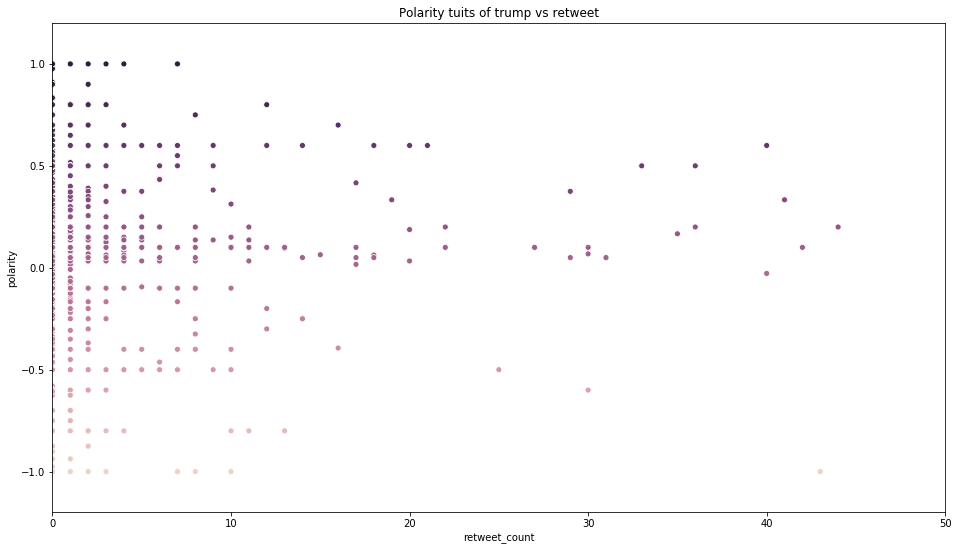

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
plt.title(f'Polarity tuits of {topico_a} vs retweet')
plt.xlim(0,50)
plt.ylim(-1.2,1.2)
sns.scatterplot(data=df_af, x='retweet_count', y="polarity", hue="polarity", legend=False, ax=ax)
plt.savefig('images/a_polarity.png')

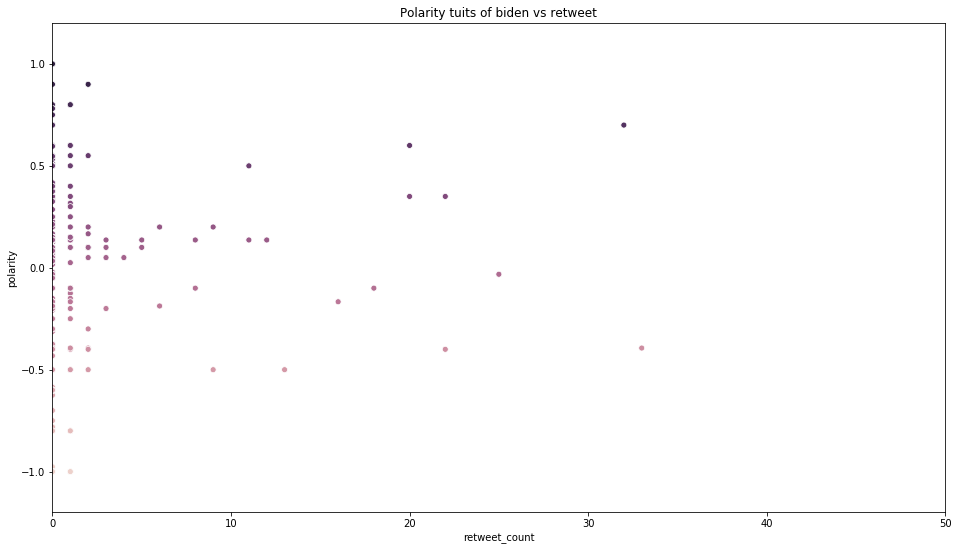

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
plt.title(f'Polarity tuits of {topico_b} vs retweet')
plt.xlim(0,50)
plt.ylim(-1.2,1.2)
sns.scatterplot(data=df_bf, x='retweet_count', y="polarity", hue="polarity", legend=False, ax=ax)
plt.savefig('images/b_polarity.png')

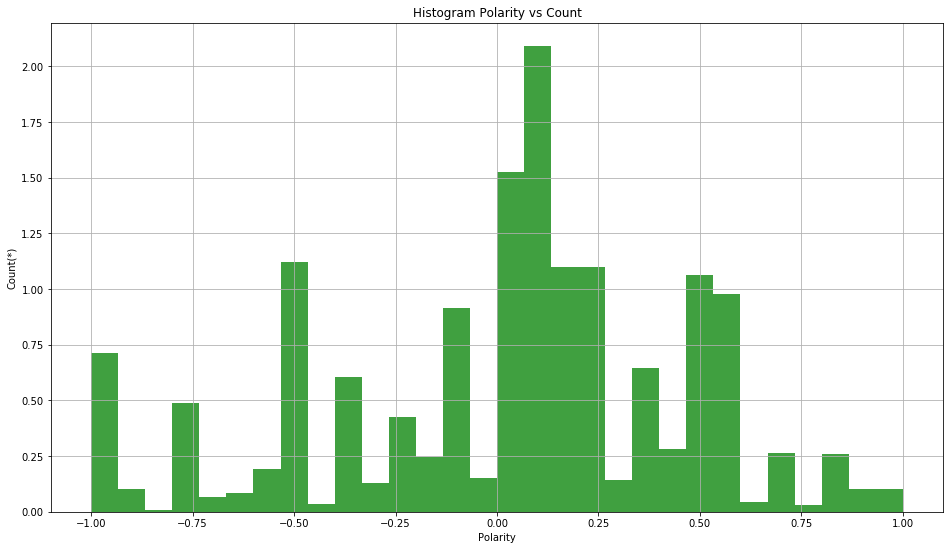

In [63]:
plt.figure(figsize=(16,9), facecolor=None)
plt.hist(df_af['polarity'], bins=30, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Polarity')
plt.ylabel('Count(*)')
plt.title('Histogram Polarity vs Count')
plt.grid(True)
plt.savefig('images/a_hist.png')
plt.show()

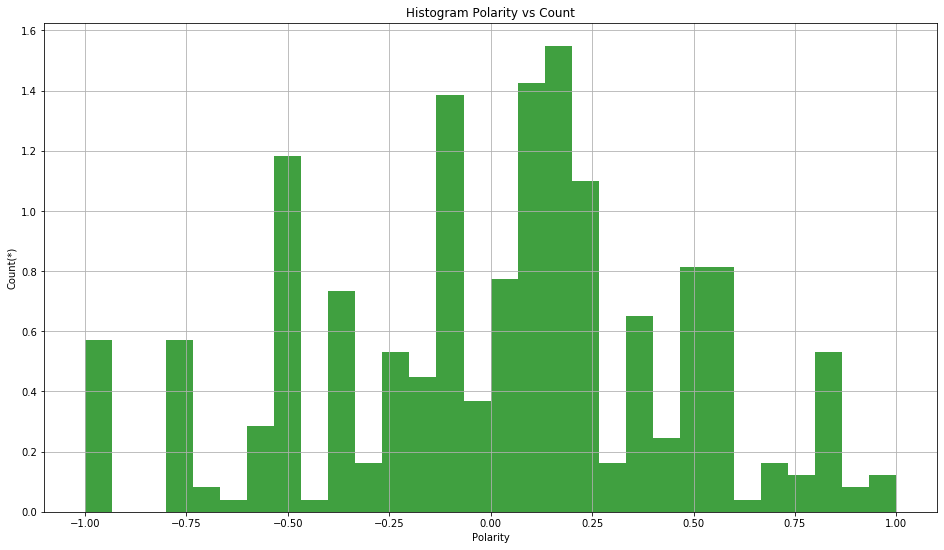

In [64]:
plt.figure(figsize=(16,9), facecolor=None)
plt.hist(df_bf['polarity'], bins=30, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Polarity')
plt.ylabel('Count(*)')
plt.title('Histogram Polarity vs Count')
plt.grid(True)
plt.savefig('images/b_hist.png')
plt.show()

In [65]:
def geo_to_number(list_geo):
    geo_return = []
    for geo in list_geo:
        geo = geo[0].split(',')
        geo = [float(geo[0]),float(geo[1])]
        geo_return.append(geo)
    return list(geo_return)

In [66]:
map1 = folium.Map(
    location=[-13.9837562,-56.8230086],
    zoom_start=4,
    #tiles='cartodbpositron',
    tiles='CartoDB dark_matter'
)
for geo in geo_to_number(cred.geo_data):
    folium.Marker(location=geo, icon=folium.Icon(color='blue') ).add_to(map1)
    #folium.CircleMarker(location=geo).add_to(map1)
#map1.save("my_map.html")
map1
